## Crypto Market Sentiment Analysis with NLP 

## Data overview

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


import ast, re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [60]:
df = pd.read_csv("cryptonews.csv")

In [61]:
df.head(10)

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...
5,2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subj...",CryptoPotato,bitcoin,Yonsei found that during BTC’s rally in early ...,Is This Why Bitcoin’s Price Rally Was Halted? ...,https://cryptopotato.com/is-this-why-bitcoins-...
6,2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjec...",CryptoNews,bitcoin,Cathie Wood led ARK Invest fund sold around 80...,Cathie Wood’s Ark Invest Sells $27.6 Million i...,https://cryptonews.comhttps://cryptonews.com/n...
7,2023-12-19 04:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,Bitcoin's 150% surge pales in comparison to th...,Bitcoin Soared 150% in 2023 But These Companie...,https://cryptopotato.com/bitcoin-soared-150-in...
8,2023-12-19 04:00:01,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,The South Korean city of Busan is edging close...,South Korean City Busan Names Digital Exchange...,https://cryptonews.comhttps://cryptonews.com/n...
9,2023-12-19 02:59:59,"{'class': 'negative', 'polarity': -0.08, 'subj...",CoinTelegraph,bitcoin,The SEC has pushed back its decision on a rost...,"SEC delays several Ethereum ETFs, pushing fina...",https://cointelegraph.com/news/sec-delays-ethe...


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31037 entries, 0 to 31036
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       31037 non-null  object
 1   sentiment  31037 non-null  object
 2   source     31037 non-null  object
 3   subject    31037 non-null  object
 4   text       31037 non-null  object
 5   title      31037 non-null  object
 6   url        31037 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


## Feature engineering

In [63]:
df = df.drop("url", axis = 1)

In [64]:
df = df.sort_values(by = "date", ascending = True).reset_index(drop = True)

In [65]:
df['sentiment'] = df['sentiment'].apply(lambda x: ast.literal_eval(x)['class'] if isinstance(x, str) else None)

In [66]:
df.date = pd.to_datetime(df['date'], format = "mixed").dt.to_period('M')

In [67]:
df.sample(1)

,date,sentiment,source,subject,text,title
7177,2022-06,positive,CryptoPotato,altcoin,"Although crypto winter is here, investors shou...",Indian Crypto Excange CoinDCX Extends Withdraw...


In [68]:
for col in df.columns: 
    print(f"{col}: {len(df[col].unique())}")

date: 27
sentiment: 3
source: 3
subject: 6
text: 30423
title: 30964


In [69]:
print(df['date'].min(), df['date'].max())

2021-10 2023-12


## Data visualization

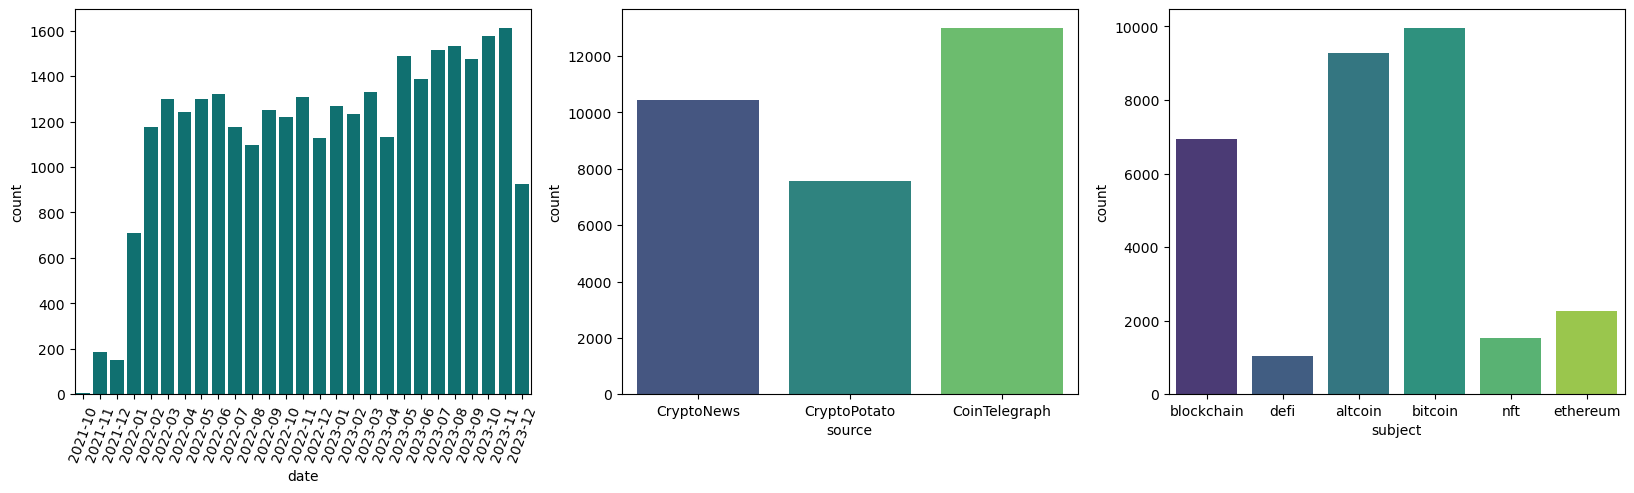

In [135]:
fig, sub = plt.subplots(1, 3, figsize = (20, 5))

sns.barplot(df['date'].value_counts().sort_index(), ax = sub[0], color = "teal")
sub[0].set_xticks(range(len(df['date'].value_counts().sort_index().index)))  
sub[0].set_xticklabels(df['date'].value_counts().sort_index().index, rotation=70)

sns.countplot(x="source", data=df, ax=sub[1], hue="source", legend=False, palette="viridis")

sns.countplot(x="subject", data=df, ax=sub[2], hue="subject", legend=False, palette="viridis")

plt.show()

In [71]:
positive = df[df.sentiment == "positive"]
neutral = df[df.sentiment == "neutral"]
negative = df[df.sentiment == "negative"]

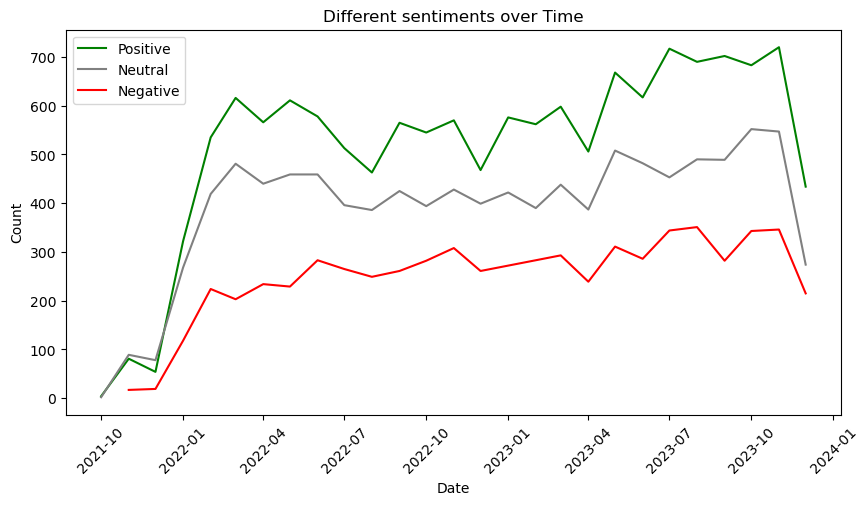

In [72]:
plt.figure(figsize = (10, 5))
sns.lineplot(x = pd.period_range('2021-10', '2023-12', freq='M').to_timestamp(), y = positive.groupby("date").count().sentiment, 
             color = "green", 
             label = "Positive")

sns.lineplot(x = pd.period_range('2021-10', '2023-12', freq='M').to_timestamp(), y = neutral.groupby("date").count().sentiment, 
             color = "grey", 
             label = "Neutral")

sns.lineplot(x = pd.period_range('2021-11', '2023-12', freq='M').to_timestamp(), y = negative.groupby("date").count().sentiment, 
             color = "red", 
             label = "Negative")

plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(loc = "upper left")
plt.xticks(rotation = 45)
plt.title("Different sentiments over Time")
plt.show()

In [73]:
len(positive) / len(df) * 100, len(neutral) / len(df) * 100, len(negative) / len(df) * 100

(44.991461803653706, 34.00779714534266, 21.00074105100364)

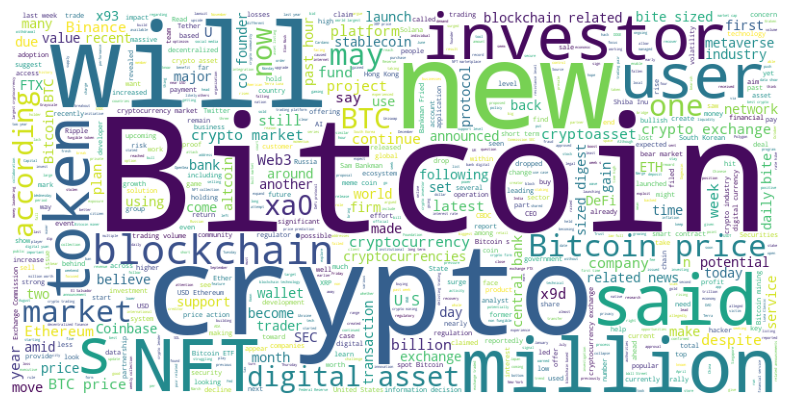

In [ ]:
text_data = " ".join(df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=10000).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

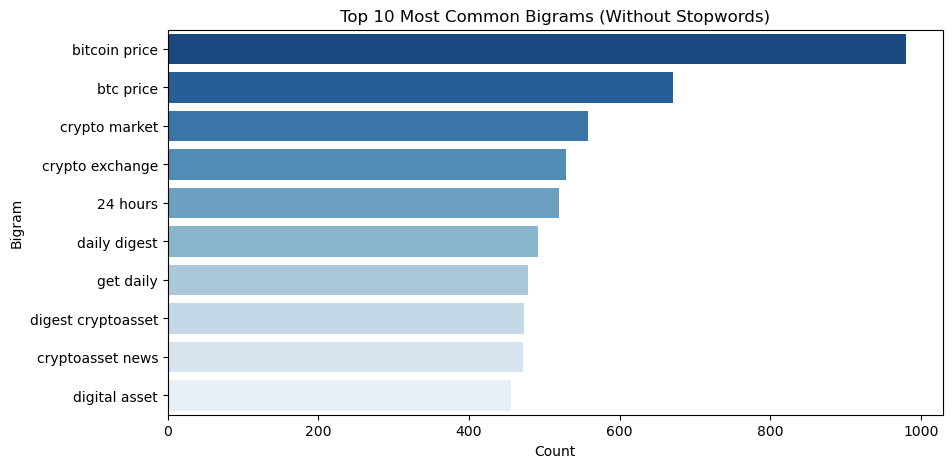

In [81]:
stop_words = set(stopwords.words("english"))

def get_bigrams(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    bigrams = list(nltk.bigrams(words))
    return [" ".join(bigram) for bigram in bigrams]

bigrams = []
for t in df["text"]:
    bigrams.extend(get_bigrams(t))

bigram_counts = Counter(bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Bigram", data=bigram_df, hue = "Bigram", palette="Blues_r")
plt.title("Top 10 Most Common Bigrams (Without Stopwords)")
plt.show()

## Data preparation

In [18]:
X = df["text"]
y = df["sentiment"]

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    text = text.strip()
    return text

X = X.apply(lambda x: clean_text(x))

In [20]:
def tokenize(text):
    tokens = word_tokenize(text)
    return " ".join(tokens)

X = X.apply(lambda x: tokenize(x))

In [21]:
def sentence_vector(sentence):
    words = sentence.split()
    word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)


X = X.apply(lambda x: sentence_vector(x))

In [22]:
le = LabelEncoder()
y = le.fit_transform(y)

X = np.vstack(X)

In [23]:
X.shape

(31037, 300)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Classic ML models

In [28]:
def classic_ml_models(X_train, y_train, X_test, y_test):
    models = [RandomForestClassifier(), XGBClassifier(), LogisticRegression(max_iter=1000), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), LGBMClassifier(verbose = -1)]
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"{model.__class__.__name__} Accuracy: {round(accuracy_score(y_test, y_pred),2)}")

classic_ml_models(X_train, y_train, X_test, y_test)

RandomForestClassifier Accuracy: 0.54
XGBClassifier Accuracy: 0.61
LogisticRegression Accuracy: 0.62
GaussianNB Accuracy: 0.5
KNeighborsClassifier Accuracy: 0.5
DecisionTreeClassifier Accuracy: 0.43
LGBMClassifier Accuracy: 0.61


## Deep Learning models

In [163]:
X = df["text"]
X = X.apply(clean_text)

In [164]:
text_lengths = df["text"].apply(lambda x: len(x.split()))
print("Mean length:", np.mean(text_lengths))
print("95th percentile:", np.percentile(text_lengths, 95))

Mean length: 22.241647066404614
95th percentile: 35.0


In [165]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

max_length = 35
X_padded = keras.preprocessing.sequence.pad_sequences(X_sequences, maxlen=max_length, padding="post")

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)